In [1]:
import warnings
from typing import Any
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score, auc
from sklearn.feature_selection import RFECV
import optuna
import optuna.trial
import optuna.logging

from utils import plot_roc
import ml_utils as utils
from ml_utils import (
    get_weights_for_roc_auc, weighted_roc_metric, weighted_fpr_roc_metric, 
    get_optimal_trs, plot_roc, get_tpr_fpr, plot_roc_curves
)
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# aft, magn > 6.0

## read 

In [2]:
dataset_type_train = "magn_6_aft"
dataset_type_test = "magn_6_aft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}_trs6.0.parquet"
test_path = f"data/dataset/{dataset_type_test}_trs6.0.parquet"

In [3]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_6_aft_trs6.0.parquet
test_path: data/dataset/magn_6_aft_test_trs6.0.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-17 — 2020-08-13
test dates: 2020-10-14 — 2023-05-09

train: target==0: 524970, target==1: 1980
test: target==0: 210320, target==1: 730
target class proportion: test: 0.0034709014834537846, train: 0.0037716440939482257


In [4]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [5]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [6]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [7]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [8]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [9]:
roc_auc_weights_test

array([0.03846154, 0.03846154, 0.03846154, ..., 0.00240385, 0.00240385,
       0.00240385])

In [10]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(211050,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08413462, 0.08653846,
        0.09134615, 0.09375   , 0.09615385, 0.09855769, 0.10096154,
        0.10336538, 0.10576923, 0.10817308, 0.11057692, 0.11298077,
        0.11538462, 0.11778846, 0.125     , 0.12740385, 0.12980769,
        0.13701923, 0.13942308, 0.14182692, 0.14423077, 0.14663462,
        0.15625   , 0.15865385, 0.17067308, 0.17548077, 0.18269231,
        0.19471154, 0.20192308, 0.20673077, 0.20913462, 0.21394231,
        0.21634615, 0.22596154, 0.22836538, 0.23557692, 0.24278846,
        0.25      , 0.25721154, 0

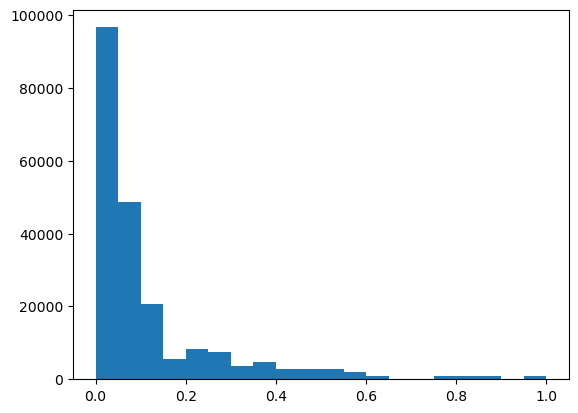

In [11]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [12]:
y_train = y_train[target]
y_test = y_test[target]

In [13]:
y_train.sum(), y_test.sum()

(1980, 730)

## logreg

In [14]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [15]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-17, 2015-10-31], len: 133650 | test: [2015-11-01, 2017-06-30], len: 136800
train: [2014-03-17, 2017-06-30], len: 270450 | test: [2017-07-01, 2019-02-28], len: 136800
train: [2014-03-17, 2019-02-28], len: 407250 | test: [2019-03-01, 2020-08-13], len: 119700


### baseline

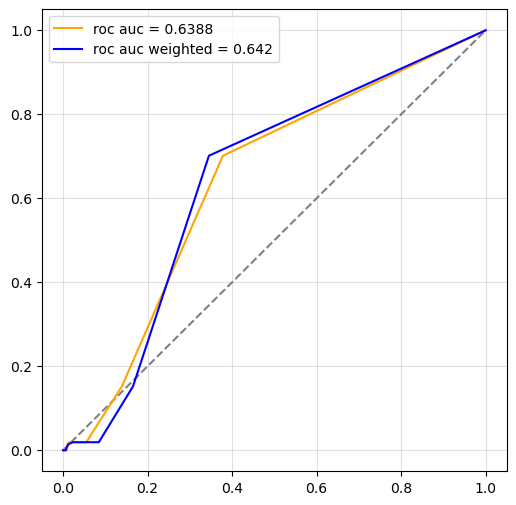

In [16]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(feature_cols, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

### rfecv feature selection

In [17]:
rfecv_features = train.logreg_rfe_select(
    X_train, y_train, feature_cols, cv, params=None, min_features_to_select=10, step=5, n_jobs=20
)

Optimal number of features: 72


In [18]:
rfecv_features

['max_magn_90_rad3',
 'std_magn_1825_rad5',
 'std_magn_3650_rad0',
 'mean_magn_1825_rad5',
 'count_earthquakes_365_rad3',
 'mean_magn_3650_rad5',
 'count_earthquakes_1095_rad5',
 'max_magn_1825_rad0',
 'max_magn_365_rad5',
 'std_magn_3650_rad3',
 'mean_magn_60_rad5',
 'max_magn_1825_rad3',
 'max_magn_90_rad5',
 'std_magn_60_rad3',
 'std_magn_180_rad3',
 'mean_magn_365_rad3',
 'std_magn_180_rad5',
 'std_magn_90_rad5',
 'mean_magn_1825_rad3',
 'min_magn_90_rad3',
 'std_magn_365_rad3',
 'min_magn_1825_rad5',
 'count_earthquakes_1095_rad0',
 'count_earthquakes_3650_rad5',
 'count_earthquakes_2555_rad3',
 'count_earthquakes_180_rad3',
 'mean_magn_90_rad5',
 'min_magn_1095_rad3',
 'std_magn_90_rad3',
 'count_earthquakes_1095_rad3',
 'count_earthquakes_3650_rad3',
 'count_earthquakes_365_rad5',
 'count_earthquakes_60_rad5',
 'min_magn_1825_rad0',
 'mean_magn_3650_rad3',
 'count_earthquakes_2555_rad5',
 'mean_magn_90_rad3',
 'mean_magn_2555_rad5',
 'min_magn_3650_rad5',
 'count_earthquakes_255

In [19]:
utils.get_features_dict(rfecv_features)

{0: [3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

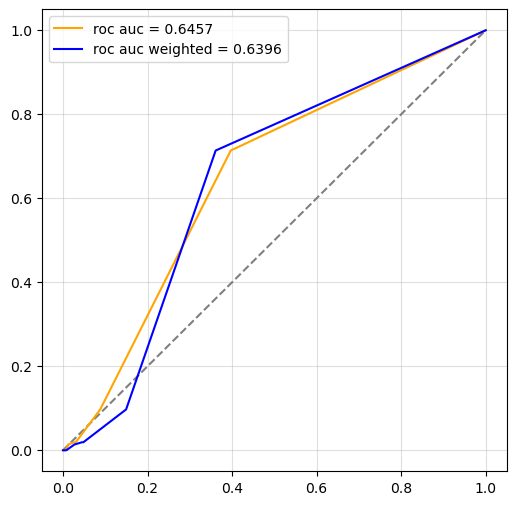

In [20]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(rfecv_features, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)


plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [21]:
(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.9115901485856912, 0.6342964243657414)

### hyper optimiziation

In [22]:
def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "max_iter": 1500,
        "penalty": "l2",
        "random_state": 42,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": 1.0,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": trial.suggest_float("C", 0.001, 100.0),
    }
    params.update(kwargs)

    return params

tuned_logreg = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 100,
    dump_study_path = f"data/optuna_res/logreg_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_logreg_model(rfecv_features, default_params()),
    n_jobs = 20,
    model_name = "logisticregression",
)

using MonthlyTimeSeriesSplit


logisticregression hyperoptimisation:   1%|          | 1/100 [00:24<39:59, 24.24s/it]/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docu

In [23]:
tuned_logreg_params = tuned_logreg["logisticregression"].get_params()
tuned_logreg_params

{'C': 0.06424211417941217,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

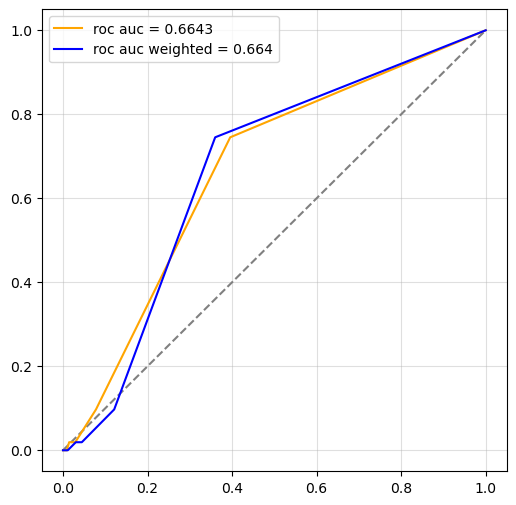

In [24]:
reulst_aft_logreg = tuned_logreg.fit(X_train, y_train)
y_pred_prob = reulst_aft_logreg.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [25]:
(
    roc_auc_score(y_train, reulst_aft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.9061142546288841, 0.6596433647097444)

In [26]:
joblib.dump(reulst_aft_logreg, "data/models/aft_6_logreg.pickle")

['data/models/aft_6_logreg.pickle']

# withoutaft, magn > 6.0

## read 

In [27]:
dataset_type_train = "magn_6_withoutaft"
dataset_type_test = "magn_6_withoutaft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}_trs6.0.parquet"
test_path = f"data/dataset/{dataset_type_test}_trs6.0.parquet"

In [28]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_6_withoutaft_trs6.0.parquet
test_path: data/dataset/magn_6_withoutaft_test_trs6.0.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-17 — 2020-08-13
test dates: 2020-10-14 — 2023-05-09

train: target==0: 237884, target==1: 1000
test: target==0: 95163, target==1: 513
target class proportion: test: 0.005390750606853504, train: 0.0042037295488557445


In [29]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [30]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [31]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [32]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [33]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [34]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(95676,
 0.6418269230769231,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04326923, 0.04567308, 0.04807692, 0.05048077,
        0.05288462, 0.05528846, 0.06490385, 0.06730769, 0.06971154,
        0.07211538, 0.07451923, 0.07932692, 0.08413462, 0.09134615,
        0.09615385, 0.09855769, 0.10096154, 0.10576923, 0.10817308,
        0.11298077, 0.11538462, 0.11778846, 0.13701923, 0.14423077,
        0.17067308, 0.20192308, 0.20673077, 0.20913462, 0.21394231,
        0.24278846, 0.27644231, 0.30048077, 0.33894231, 0.35336538,
        0.37019231, 0.37259615, 0.41105769, 0.64182692]))

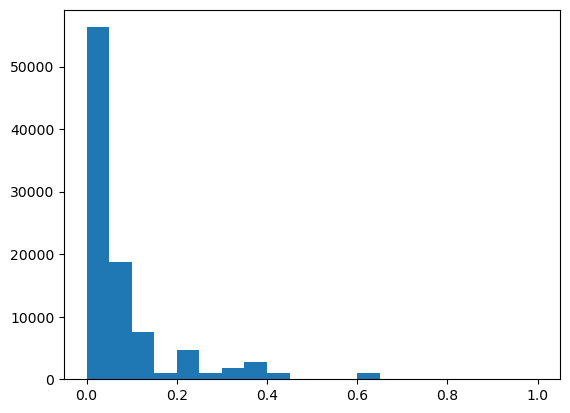

In [35]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [36]:
y_train = y_train[target]
y_test = y_test[target]

In [37]:
y_train.sum(), y_test.sum()

(1000, 513)

## logreg

In [38]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [39]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-17, 2015-10-31], len: 60588 | test: [2015-11-01, 2017-06-30], len: 62016
train: [2014-03-17, 2017-06-30], len: 122604 | test: [2017-07-01, 2019-02-28], len: 62016
train: [2014-03-17, 2019-02-28], len: 184620 | test: [2019-03-01, 2020-08-13], len: 54264


### baseline

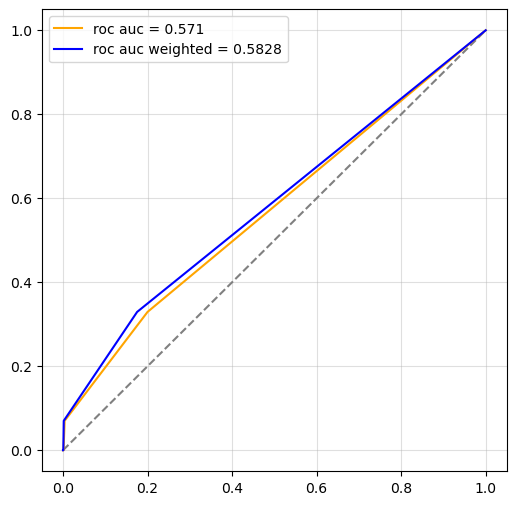

In [40]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(feature_cols, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [41]:
len(np.unique(y_pred_prob[:, 1]))

95676

In [42]:
(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

(0.8909730582973214, 0.6217551135561619)

### rfecv feature selection

In [44]:
rfecv_features = train.logreg_rfe_select(
    X_train, y_train, feature_cols, cv, params=None, min_features_to_select=10, step=5, n_jobs=20
)

Optimal number of features: 62


In [45]:
rfecv_features

['mean_magn_1825_rad5',
 'count_earthquakes_365_rad3',
 'mean_magn_3650_rad5',
 'count_earthquakes_1095_rad5',
 'mean_magn_1095_rad5',
 'max_magn_365_rad5',
 'mean_magn_60_rad5',
 'std_magn_3650_rad3',
 'max_magn_1825_rad3',
 'max_magn_90_rad5',
 'std_magn_2555_rad5',
 'std_magn_365_rad5',
 'std_magn_180_rad3',
 'std_magn_180_rad5',
 'std_magn_90_rad5',
 'mean_magn_1825_rad3',
 'std_magn_365_rad3',
 'min_magn_1825_rad5',
 'count_earthquakes_3650_rad5',
 'count_earthquakes_180_rad3',
 'day_of_year_cos',
 'dt_month',
 'std_magn_90_rad3',
 'day_of_year',
 'count_earthquakes_3650_rad3',
 'std_magn_3650_rad5',
 'count_earthquakes_60_rad5',
 'count_earthquakes_1825_rad3',
 'mean_magn_3650_rad3',
 'count_earthquakes_2555_rad5',
 'mean_magn_2555_rad5',
 'min_magn_3650_rad5',
 'max_magn_3650_rad5',
 'max_magn_1825_rad5',
 'min_magn_1825_rad3',
 'max_magn_3650_rad0',
 'min_magn_365_rad5',
 'std_magn_2555_rad3',
 'count_earthquakes_90_rad3',
 'min_magn_60_rad5',
 'max_magn_2555_rad5',
 'min_magn_

In [46]:
utils.get_features_dict(rfecv_features)

{0: [10], 3: [0, 1, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

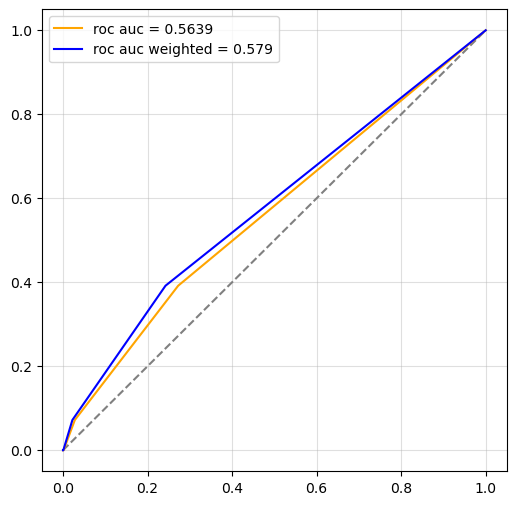

In [47]:
params = {
    "C": 1.0,
    "max_iter": 1500,
}

logreg_model = train.get_logreg_model(rfecv_features, params)

logreg_model = logreg_model.fit(X_train, y_train)
y_pred_prob = logreg_model.predict_proba(X_test)


(
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1])
)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

### hyper optimiziation

In [48]:
def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "max_iter": 1500,
        "penalty": "l2",
        "random_state": 42,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": 1.0,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "C": trial.suggest_float("C", 0.001, 100.0),
    }
    params.update(kwargs)

    return params

tuned_logreg = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 100,
    dump_study_path = f"data/optuna_res/logreg_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_logreg_model(rfecv_features, default_params()),
    n_jobs = 20,
    model_name = "logisticregression",
)

using MonthlyTimeSeriesSplit


logisticregression hyperoptimisation:   8%|▊         | 8/100 [02:17<24:03, 15.69s/it]/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
logisticregression hyperoptimisation: 100%|██████████| 100/100 [22:07<00:00, 13.27s/it]


In [49]:
tuned_logreg_params = tuned_logreg["logisticregression"].get_params()
tuned_logreg_params

{'C': 0.14213230293126455,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

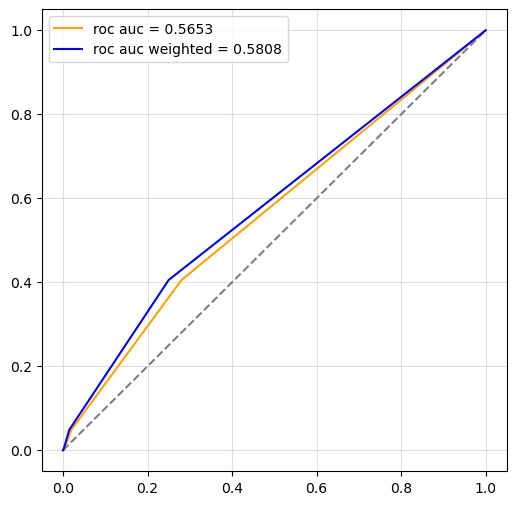

In [50]:
reulst_withoutaft_logreg = tuned_logreg.fit(X_train, y_train)
y_pred_prob = reulst_withoutaft_logreg.predict_proba(X_test)

plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=100)

In [51]:
(
    roc_auc_score(y_train, reulst_withoutaft_logreg.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
)

(0.8811438432177028, 0.6410100109550416)

In [52]:
joblib.dump(reulst_withoutaft_logreg, "data/models/withoutaft_6_logreg.pickle")

['data/models/withoutaft_6_logreg.pickle']